In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
import array_to_latex
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')

backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
n_steps=100
time=np.pi
#initial_state={"110": 1}
shots = 32000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                    0,                    0,                    0,                    0,                    0,                    0,   0],
[  0,      1.0 + 0.00103*I,   9.9e-5 + 0.00103*I,                    0, -9.58e-5 - 0.00206*I,                    0,                    0,   0],
[  0, -9.58e-5 + 0.00103*I,      1.0 - 0.00206*I,                    0,   9.9e-5 + 0.00103*I,                    0,                    0,   0],
[  0,                    0,                    0,      1.0 + 0.00103*I,                    0, -9.58e-5 + 0.00103*I,   9.9e-5 - 0.00206*I,   0],
[  0,   9.9e-5 - 0.00206*I, -9.58e-5 + 0.00103*I,                    0,      1.0 + 0.00103*I,                    0,                    0,   0],
[  0,                    0,                    0,   9.9e-5 + 0.00103*I,                    0,      1.0 - 0.00206*I, -9.58e-5 + 0.00103*I,   0],
[  0,                    0,                    0, -9.58e-5 - 0.00206*I,                    0,   9.9e-5 + 0.00103*I,      1.0 + 

In [3]:
A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

## building the operator U gate

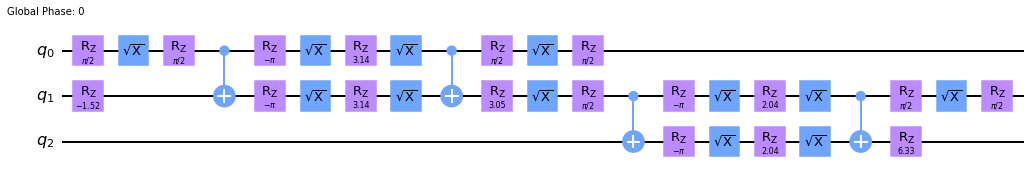

In [4]:

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [5]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[     0.999999467211835 - 0.0010322674298842*I,  7.34153473888526e-18 - 1.08166144138023e-16*I, -1.79725667951042e-16 - 4.72816739693836e-16*I,  7.16209974402798e-21 + 5.96265451892723e-20*I, -7.40675229641317e-17 + 5.60328659302666e-17*I, -5.33126057911139e-22 - 7.26270750317739e-20*I,   2.7044117201282e-17 - 1.56108913490346e-18*I,                6.3080416e-33 - 6.0591776e-33*I],
[ 1.5600580172332e-17 - 5.34076783561783e-17*I,      0.999996793791179 - 0.00103226467019748*I,  -0.000110777440203341 + 0.00230966780561924*I, -7.79384455946312e-18 - 4.68544148153184e-16*I,                3.5661627e-33 + 4.7201013e-33*I,  1.25629619599248e-17 + 5.41646975035266e-17*I, -1.15414284741767e-19 - 1.86864873783156e-19*I,  -2.9201216515468e-18 - 6.90110258878467e-19*I],
[8.93725720290126e-17 - 2.66340636146498e-16*I,    9.58137779616048e-5 + 0.00103226467019815*I,       0.447910641997747 - 0.0195393926101164*I, -4.21131365927571e-17 - 4.49783877464153e-17*I,     -0.89386371600091 + 0.000

## building the evolution circuit

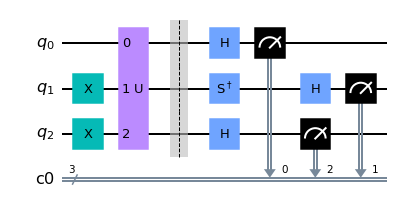

In [6]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

## building the calibration matrices

In [7]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

## building the itself calibration circuit: *Circuit-Itself-Calibration (CIC)*

In [8]:
Number_of_tomography_basis = 3**3

circuits_calibration_itself = list(range(Number_of_tomography_basis))

for tomography_base in range(Number_of_tomography_basis):

    circuits_calibration_itself[tomography_base] = []

    for i in state_labels:

        cr_cal_itself = ClassicalRegister(3)
        qr_cal_itself = QuantumRegister(3)
        qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}") # changing the name to not have API contrast

        for k in range(3):
            if i[::-1][k] == "1":
                qc_cal_itself.x(qr_cal_itself[k])

        qc_cal_itself.append(qc_U, qr_cal_itself)
        qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

        circuits_calibration_itself[tomography_base].append(qc_cal_itself)

    


## building the identity calibration circit: *Noisy-Identity-Calibration (NIC)*

In [9]:
calib_circuits_identity = []

for i in state_labels:

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_id.measure(qr_cal_id, cr_cal_id)

    calib_circuits_identity.append(qc_cal_id)

## execution of the circuits

In [10]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[1,3,5])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[1,3,5])

jobs_cal_our_itself = []
for tomography_base_calibration_circuits in circuits_calibration_itself:
    job_tomography_itself=execute(tomography_base_calibration_circuits, backend = backend, shots=shots, initial_layout=[1,3,5])
    jobs_cal_our_itself.append(job_tomography_itself)

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[1,3,5])

## building the matrices of the probabilies for the qiskit, identity and circuit-itself calibrations

In [11]:
meas_fitter_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)

meas_fitter_itself_list = []
for job_cal_our_itself in jobs_cal_our_itself:
    meas_fitter_itself_list.append(CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels))

meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

## building the calibration matrix for each circuit of the tomography

In [12]:
U_tilde_identity=meas_fitter_identity.cal_matrix

U_tilde_itself_list = []
for meas_fitter_itself in meas_fitter_itself_list:
    U_tilde_itself_list.append(meas_fitter_itself.cal_matrix)

U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [13]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

## building the matrix of the tomography basis 


In [14]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

In [15]:
C_matrices_itself = []
C_matrices_identity = []

C_identity = U_tilde_identity

for tomography_base in range(Number_of_tomography_basis):

    print(tomography_base)
    qcs_basis[tomography_base].remove_final_measurements()
    #base_matrix = matrix_from_circuit(qcs_basis[tomography_base], type="numpy")
    #base_matrix_inverse = np.linalg.inv(base_matrix)

    base_matrix_amplitudes = matrix_from_circuit(qcs_basis[tomography_base], type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    # inverting the ideal matrix of the circuit

    U_ideal_inverse = np.linalg.inv(U_ideal)
    U_ideal_inverse_abs = np.abs(U_ideal_inverse)**2

    U_ideal_abs = np.abs(U_ideal)**2
    U_ideal_abs_inverse = np.linalg.inv(U_ideal_abs)

    base_matrix_inverse_abs = np.abs(base_matrix_inverse)

    U_ideal_H_abs_inverse = np.dot(U_ideal_inverse_abs, base_matrix_inverse_abs)

    #U_ideal_H_abs = np.abs(U_ideal_H)**2
    #U_ideal_H_inv = np.linalg.inv(U_ideal_H_abs)

    

    C_itself = np.dot(U_tilde_itself_list[tomography_base], U_ideal_H_abs_inverse)

    #C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.matmul(base_matrix, np.matmul(C_identity, base_matrix_inverse))

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_itself))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [16]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for i, C_new in enumerate(C_matrices_itself):
    meas_fitter_our_aus = deepcopy(meas_fitter_itself_list[0])
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [17]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [18]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

for i in range(27):

    old_counts=raw_res.get_counts(i)
    
    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [19]:
identity_res.get_counts(0)

{'000': 4000.0507416764067,
 '001': 4000.0470127342455,
 '010': 4000.1284830634704,
 '011': 4000.0154719803827,
 '100': 3999.9551240955857,
 '101': 3999.966371707234,
 '110': 3999.888522514035,
 '111': 3999.9482722286366}

In [20]:
itself_res.get_counts(-1)

{'000': 6.96499948644666e-12,
 '001': 1.4583712926521941e-12,
 '110': 32000.0,
 '111': 8.42138065486049e-12}

In [21]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.85958472, 0.95980448, 0.99679371, 0.99998863])